# WGAN-GP (Conv) on Fashion-MNIST (Portfolio Version)

This notebook adapts a class WGAN-GP implementation to a **more portfolio-friendly dataset** (Fashion-MNIST) and a **more standard image GAN architecture** (small Conv / DCGAN-style).

**Included in notebook:**
- WGAN-GP objective with gradient penalty
- Conv Generator + Conv Critic (no sigmoid)
- Fixed-noise sample grids saved each epoch
- Loss curves + brief observations

## 1) Setup

In [1]:
# !pip uninstall -y pillow
# !pip install -q --no-cache-dir "pillow==10.3.0"

import math, os, random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
from tqdm import tqdm
import PIL

seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("torch:", torch.__version__)
print("torchvision:", __import__("torchvision").__version__)
print("pillow:", PIL.__version__)

Device: cuda
torch: 2.9.0+cu126
torchvision: 0.24.0+cu126
pillow: 11.3.0


## 2) Config

In [2]:
cfg = {
    # Data
    "dataset": "FashionMNIST",   # "MNIST" or "FashionMNIST"
    "image_size": 28,
    "channels": 1,

    # Model
    "latent_dim": 128,
    "g_base": 64,               # base channels for G
    "d_base": 64,               # base channels for D

    # Training
    "batch_size": 128,
    "lr": 2e-4,
    "betas": (0.0, 0.9),
    "n_critic": 5,
    "lambda_gp": 10.0,
    "epochs": 10,               # a bit longer for FashionMNIST
    "sample_every": 1,
    "num_samples": 64,

    # Outputs
    "save_dir": "./wgangp_fashion_conv"
}
cfg

{'dataset': 'FashionMNIST',
 'image_size': 28,
 'channels': 1,
 'latent_dim': 128,
 'g_base': 64,
 'd_base': 64,
 'batch_size': 128,
 'lr': 0.0002,
 'betas': (0.0, 0.9),
 'n_critic': 5,
 'lambda_gp': 10.0,
 'epochs': 10,
 'sample_every': 1,
 'num_samples': 64,
 'save_dir': './wgangp_fashion_conv'}

## 3) Data

In [3]:
transform = transforms.Compose([
    transforms.Resize(cfg["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # map to [-1, 1]
])

ds_cls = getattr(datasets, cfg["dataset"])
train_ds = ds_cls(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True, num_workers=2, pin_memory=True)

print("Dataset:", cfg["dataset"], "| N:", len(train_ds))

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 2.15MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.6MB/s]

Dataset: FashionMNIST | N: 60000


## 4) Models (Conv / DCGAN-lite)

In [4]:
# Notes:
# - Output size is 28x28. We'll upsample 7x7 -> 14x14 -> 28x28.
# - Critic outputs a scalar (no sigmoid).

class ConvGenerator(nn.Module):
    def __init__(self, z_dim, out_ch=1, base=64):
        super().__init__()
        self.net = nn.Sequential(
            # z -> (base*4) x 7 x 7
            nn.ConvTranspose2d(z_dim, base*4, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(base*4),
            nn.ReLU(True),

            # 7x7 -> 14x14
            nn.ConvTranspose2d(base*4, base*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base*2),
            nn.ReLU(True),

            # 14x14 -> 28x28
            nn.ConvTranspose2d(base*2, base, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base),
            nn.ReLU(True),

            # final conv
            nn.Conv2d(base, out_ch, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.net(z)

class ConvCritic(nn.Module):
    def __init__(self, in_ch=1, base=64):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, base, kernel_size=4, stride=2, padding=1),  # 28->14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base, base*2, kernel_size=4, stride=2, padding=1), # 14->7
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base*2, base*4, kernel_size=3, stride=1, padding=1), # 7->7
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear((base*4) * 7 * 7, 1)
        )

    def forward(self, x):
        h = self.features(x)
        out = self.head(h)
        return out.view(-1)

G = ConvGenerator(cfg["latent_dim"], cfg["channels"], cfg["g_base"]).to(device)
D = ConvCritic(cfg["channels"], cfg["d_base"]).to(device)

print(sum(p.numel() for p in G.parameters()), "G params")
print(sum(p.numel() for p in D.parameters()), "D params")

2262465 G params
440001 D params


## 5) WGAN-GP utilities + optimizers

In [5]:
def gradient_penalty(D, real, fake):
    bsz = real.size(0)
    epsilon = torch.rand(bsz, 1, 1, 1, device=real.device, requires_grad=True)
    x_hat = epsilon * real + (1 - epsilon) * fake
    d_hat = D(x_hat)
    grads = torch.autograd.grad(
        outputs=d_hat, inputs=x_hat,
        grad_outputs=torch.ones_like(d_hat),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grads = grads.view(bsz, -1)
    gp = ((grads.norm(2, dim=1) - 1.0) ** 2).mean()
    return gp

opt_D = optim.Adam(D.parameters(), lr=cfg["lr"], betas=cfg["betas"])
opt_G = optim.Adam(G.parameters(), lr=cfg["lr"], betas=cfg["betas"])

fixed_z = torch.randn(cfg["num_samples"], cfg["latent_dim"], device=device)
os.makedirs(cfg["save_dir"], exist_ok=True)

## 6) Training

In [6]:
log = {"g_loss": [], "d_loss": [], "gp": []}

for epoch in range(1, cfg["epochs"] + 1):
    G.train(); D.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{cfg['epochs']}")

    for real, _ in pbar:
        real = real.to(device)
        bsz = real.size(0)

        # ---- Train Critic ----
        for _ in range(cfg["n_critic"]):
            z = torch.randn(bsz, cfg["latent_dim"], device=device)
            fake = G(z).detach()

            d_real = D(real)
            d_fake = D(fake)

            gp = gradient_penalty(D, real, fake) * cfg["lambda_gp"]
            d_loss = -(d_real.mean() - d_fake.mean()) + gp

            opt_D.zero_grad(set_to_none=True)
            d_loss.backward()
            opt_D.step()

        # ---- Train Generator ----
        z = torch.randn(bsz, cfg["latent_dim"], device=device)
        fake = G(z)
        g_loss = -D(fake).mean()

        opt_G.zero_grad(set_to_none=True)
        g_loss.backward()
        opt_G.step()

        log["g_loss"].append(g_loss.item())
        log["d_loss"].append(d_loss.item())
        log["gp"].append(gp.item())
        pbar.set_postfix(g=float(g_loss.item()), d=float(d_loss.item()), gp=float(gp.item()))

    # ---- Save sample grid ----
    if epoch % cfg["sample_every"] == 0:
        G.eval()
        with torch.no_grad():
            samples = G(fixed_z).cpu()
        grid = vutils.make_grid(samples, nrow=int(math.sqrt(cfg["num_samples"])), normalize=True, value_range=(-1, 1))
        out_png = f"{cfg['save_dir']}/samples_epoch_{epoch:03d}.png"
        vutils.save_image(grid, out_png)
        print("Saved:", out_png)

Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/10: 100%|██████████| 469/469 [01:37<00:00,  4.83it/s, d=-3.23, g=-13.5, gp=0.289]


Saved: ./wgangp_fashion_conv/samples_epoch_001.png


Epoch 2/10: 100%|██████████| 469/469 [01:35<00:00,  4.93it/s, d=-2.16, g=-10.3, gp=0.126]


Saved: ./wgangp_fashion_conv/samples_epoch_002.png


Epoch 3/10: 100%|██████████| 469/469 [01:35<00:00,  4.93it/s, d=-3.59, g=-10.2, gp=0.324]


Saved: ./wgangp_fashion_conv/samples_epoch_003.png


Epoch 4/10: 100%|██████████| 469/469 [01:35<00:00,  4.93it/s, d=-2.24, g=-8.12, gp=0.277]


Saved: ./wgangp_fashion_conv/samples_epoch_004.png


Epoch 5/10: 100%|██████████| 469/469 [01:35<00:00,  4.93it/s, d=-2.43, g=0.2, gp=0.295]


Saved: ./wgangp_fashion_conv/samples_epoch_005.png


Epoch 6/10: 100%|██████████| 469/469 [01:35<00:00,  4.93it/s, d=-2.45, g=-4.41, gp=0.144]


Saved: ./wgangp_fashion_conv/samples_epoch_006.png


Epoch 7/10: 100%|██████████| 469/469 [01:35<00:00,  4.93it/s, d=-1.84, g=-2.97, gp=0.183]


Saved: ./wgangp_fashion_conv/samples_epoch_007.png


Epoch 8/10: 100%|██████████| 469/469 [01:35<00:00,  4.93it/s, d=-2.38, g=0.498, gp=0.151]


Saved: ./wgangp_fashion_conv/samples_epoch_008.png


Epoch 9/10: 100%|██████████| 469/469 [01:35<00:00,  4.94it/s, d=-3.22, g=-0.405, gp=0.232]


Saved: ./wgangp_fashion_conv/samples_epoch_009.png


Epoch 10/10: 100%|██████████| 469/469 [01:35<00:00,  4.93it/s, d=-2.12, g=-6.45, gp=0.218]

Saved: ./wgangp_fashion_conv/samples_epoch_010.png


## 7) Sample grids (PDF-friendly)

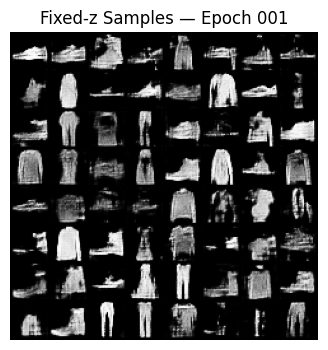

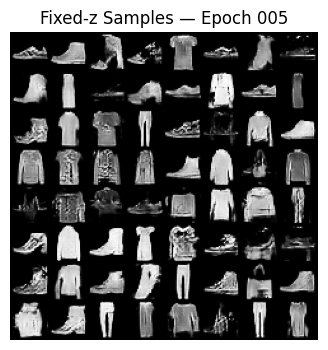

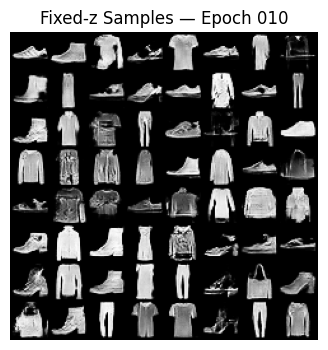

In [7]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
import os

paths = sorted(glob.glob(f"{cfg['save_dir']}/samples_epoch_*.png"))
want = ["_001", "_005", f"_{cfg['epochs']:03d}"]
show = [p for p in paths if any(w in p for w in want)] or paths[:3]

for p in show:
    img = Image.open(p)
    epoch_label = os.path.basename(p).replace("samples_epoch_", "").replace(".png", "")
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Fixed-z Samples — Epoch {epoch_label}")
    plt.show()

## 8) Loss curves

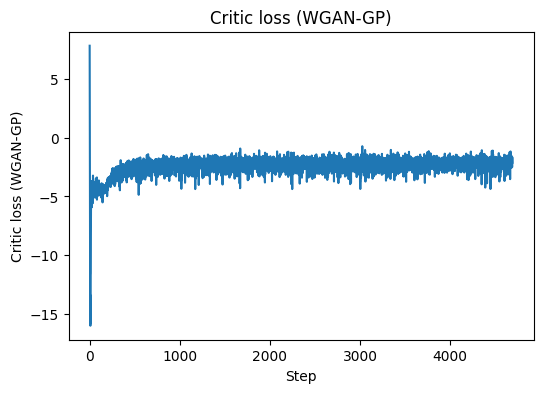

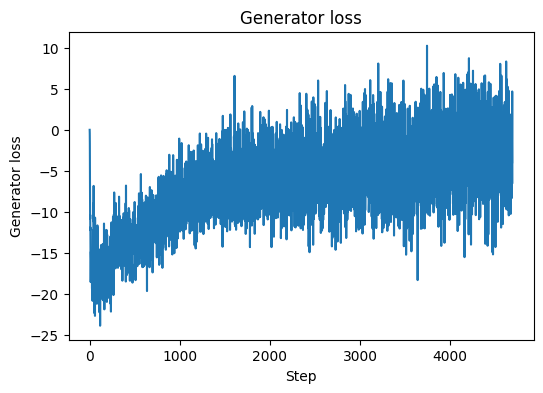

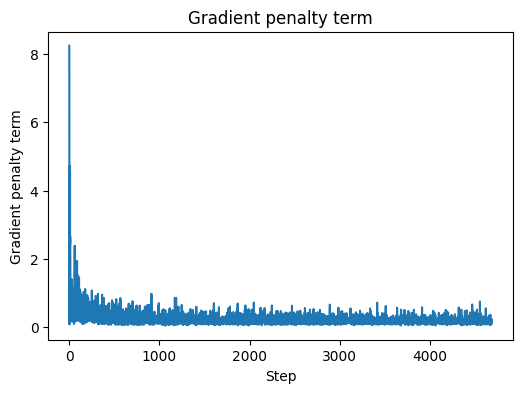

In [8]:
import matplotlib.pyplot as plt

def plot_curve(vals, title):
    plt.figure(figsize=(6,4))
    plt.plot(vals)
    plt.title(title)
    plt.xlabel("Step")
    plt.ylabel(title)
    plt.show()

plot_curve(log["d_loss"], "Critic loss (WGAN-GP)")
plot_curve(log["g_loss"], "Generator loss")
plot_curve(log["gp"], "Gradient penalty term")

## 9) Observations
- With **λ_GP=10** and **n_critic=5**, training was stable on Fashion-MNIST and samples became visually coherent over epochs.
- The **GP term staying moderate** (not exploding) coincided with improved sharpness and reduced artifacts.
- Fixed-noise grids make progression easy to see: edges/shapes sharpen and coverage improves over training.